In [1]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import json
from antropy import lziv_complexity

c:\Users\pthoe\miniconda3\envs\gpt\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\pthoe\miniconda3\envs\gpt\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\pthoe\miniconda3\envs\gpt\lib\site-packages\umap\distances.py:1086: NumbaDeprecatio

# Dimensionality Reduction Plots

In [2]:
def plot_embedding(data, data_name, embedding_type="tSNE", colors=None, kde=False, legend=True, show=True):
    vecs_all = np.concatenate(list(data.values()))
    model_ids = np.concatenate([[i] * len(vecs) for i, vecs in enumerate(data.values())])

    if embedding_type.lower() == "tsne":
        emb = TSNE(n_components=2)
    elif embedding_type.lower() == "pca":
        emb = PCA(n_components=2)
    elif embedding_type.lower() == "umap":
        emb = UMAP(n_components=2)
    else:
        raise ValueError(f"Unknown embedding type {embedding_type}")

    emb_vecs = emb.fit_transform(vecs_all)

    plt.title(f"{embedding_type} embedding ({data_name})")
    for i, name in enumerate(data.keys()):
        cluster_data = emb_vecs[model_ids == i].T
        c = colors[i] if colors is not None else f"C{i}"
        plt.scatter(*cluster_data, label=name, alpha=0.8, s=40, c=c)

        if kde:
            sns.kdeplot(x=cluster_data[0], y=cluster_data[1], fill=True, color=c, alpha=0.1, thresh=0.01, levels=2)

    plt.axis("off")
    if legend:
        plt.legend()
    if show:
        plt.show()

def summary(data_locations, data_name):
    data = load_data(data_locations)
    
    print(f"Number of samples per model ({data_name}):")
    for name, vecs in data.items():
        print("\t", name, vecs.shape[0])

    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plot_embedding(data, data_name, embedding_type="PCA", colors=colors, legend=False, show=False)
    plt.subplot(132)
    plot_embedding(data, data_name, embedding_type="tSNE", colors=colors, legend=False, show=False)
    plt.subplot(133)
    plot_embedding(data, data_name, embedding_type="UMAP", colors=colors, legend=False, show=False)
    plt.legend(loc="lower right", bbox_to_anchor=(0.2, 0))
    plt.show()

def load_data(data_locations, max_samples=100):
    data = {}
    for name, loc in data_locations.items():
        data[name] = np.array(list(json.load(open(loc, "r")).values()))[:max_samples]
    return data

Number of samples per model (flash fiction):
	 GPT-3 (temp 1.0) 99
	 GPT-3 (temp 1.2) 98
	 GPT-4 (temp 0.8) 100
	 GPT-4 (temp 1.0) 93
	 GPT-4 (temp 1.2) 86


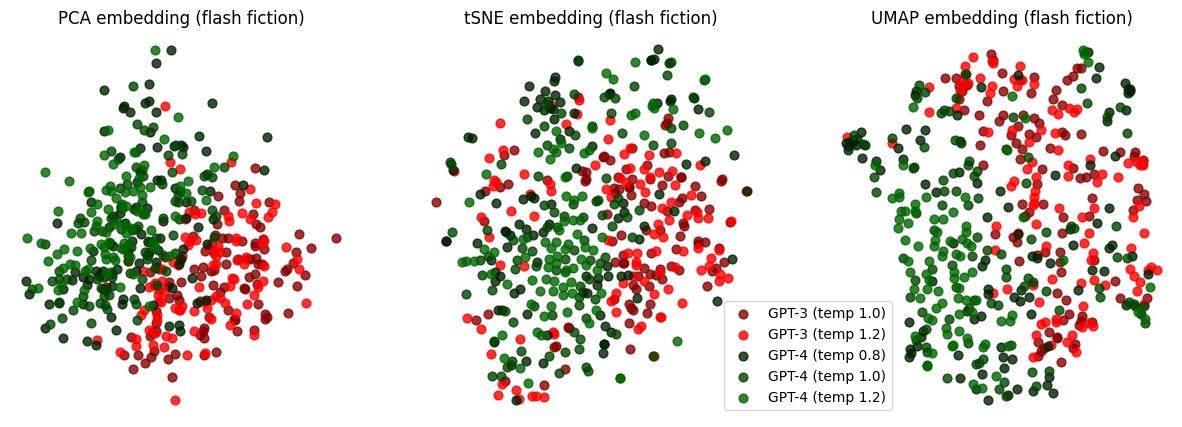

Number of samples per model (Haiku):
	 GPT-3 (temp 1.0) 93
	 GPT-3 (temp 1.5) 98
	 GPT-4 (temp 0.8) 100
	 GPT-4 (temp 1.0) 98
	 GPT-4 (temp 1.2) 100
	 GPT-4 (temp 1.4) 100
	 GPT-4 (temp 1.5) 100
	 Human 100


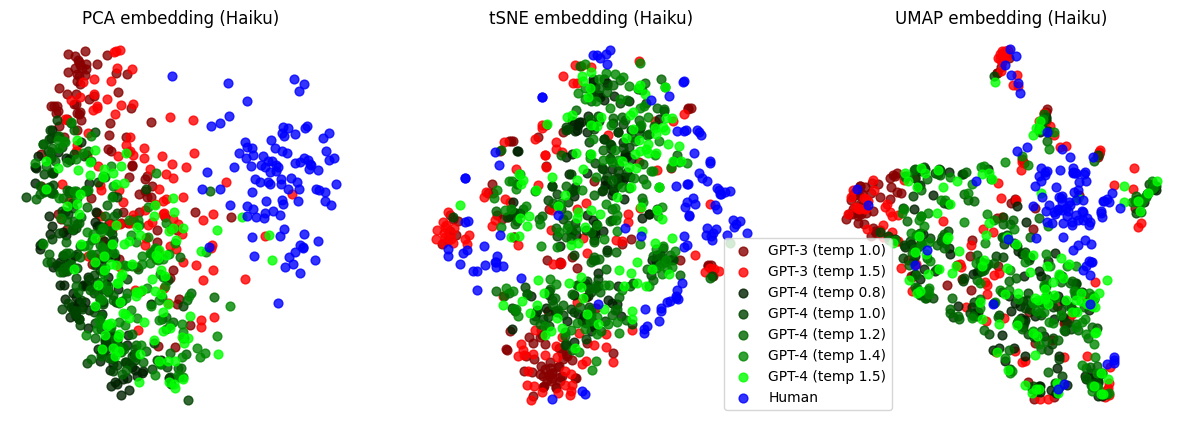

Number of samples per model (Synopsis):
	 GPT-3 (temp 1.0) 97
	 GPT-3 (temp 1.2) 98
	 GPT-4 (temp 1.0) 95
	 GPT-4 (temp 1.2) 100


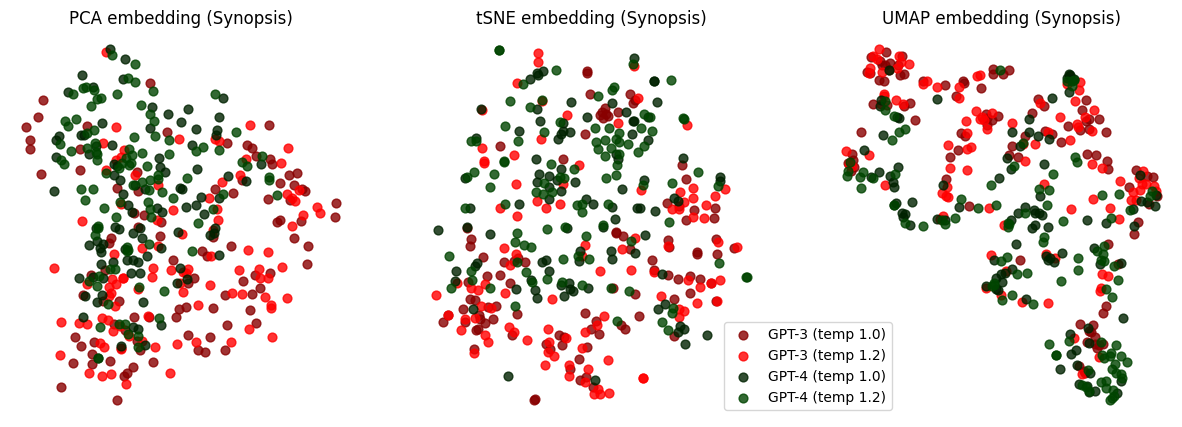

In [6]:
colors = ["#880000", "#ff0000", "#002200", "#004400", "#006600", "#008800", "#00ff00", "#0000ff"]

data_name = "flash fiction"
data_locations = {
    "GPT-3 (temp 1.0)": "../machine_data_stories/embeddings/GPT3_temp1.0_flash_fiction_nocrea100_vecs.json",
    "GPT-3 (temp 1.2)": "../machine_data_stories/embeddings/GPT3_temp1.2_flash_fiction_nocrea_vecs.json",
    "GPT-4 (temp 0.8)": "../machine_data_stories/embeddings/GPT4_temp0.8_flash_fiction_nocrea110_vecs.json",
    "GPT-4 (temp 1.0)": "../machine_data_stories/embeddings/GPT4_temp1.0_flash_fiction_nocrea100_vecs.json",
    "GPT-4 (temp 1.2)": "../machine_data_stories/embeddings/GPT4_temp1.2_flash_fiction_nocrea_vecs.json",
}
summary(data_locations, data_name)

data_name = "Haiku"
data_locations = {
    "GPT-3 (temp 1.0)": "../machine_data_stories/embeddings/GPT3_temp1.0_haiku_nocrea100_vecs.json",
    "GPT-3 (temp 1.5)": "../machine_data_stories/embeddings/GPT3_temp1.5_haiku_nocrea_vecs.json",
    "GPT-4 (temp 0.8)": "../machine_data_stories/embeddings/GPT4_temp0.8_haiku_nocrea110_vecs.json",
    "GPT-4 (temp 1.0)": "../machine_data_stories/embeddings/GPT4_temp1.0_haiku_nocrea100_vecs.json",
    "GPT-4 (temp 1.2)": "../machine_data_stories/embeddings/GPT4_temp1.2_haiku_nocrea130_vecs.json",
    "GPT-4 (temp 1.4)": "../machine_data_stories/embeddings/GPT4_temp1.4_haiku_nocrea110_vecs.json",
    "GPT-4 (temp 1.5)": "../machine_data_stories/embeddings/GPT4_temp1.5_haiku_nocrea_vecs.json",
    "Human": "../machine_data_stories/embeddings/human_haiku_tempslibres_vecs.json",
}
summary(data_locations, data_name)

data_name = "Synopsis"
data_locations = {
    "GPT-3 (temp 1.0)": "../machine_data_stories/embeddings/GPT3_temp1.0_synopsis_nocrea100_vecs.json",
    "GPT-3 (temp 1.2)": "../machine_data_stories/embeddings/GPT3_temp1.2_synopsis_nocrea_vecs.json",
    "GPT-4 (temp 1.0)": "../machine_data_stories/embeddings/GPT4_temp1.0_synopsis_nocrea100_vecs.json",
    "GPT-4 (temp 1.2)": "../machine_data_stories/embeddings/GPT4_temp1.2_synopsis_nocrea_vecs.json",
}
summary(data_locations, data_name)

# Lempel-Ziv compression

In [4]:
def complexity_plot(fnames, data_name, margin=0.03):
    texts = {name: list(json.load(open(f"../machine_data_stories/{fname}", "r")).values()) for name, fname in fnames.items()}
    
    mean, std = {}, {}
    for name, text in texts.items():
        scores = [lziv_complexity(t, normalize=True) for t in text]
        mean[name] = np.mean(scores)
        std[name] = np.std(scores)

    plt.figure()
    plt.title(f"Lempel-Ziv complexity ({data_name})")
    plt.bar(range(len(mean)), list(mean.values()), yerr=list(std.values()))
    plt.xticks(range(len(mean)), list(mean.keys()), rotation=45, ha="right")
    plt.ylim(min(mean.values()) - margin, max(mean.values()) + margin)
    plt.show()

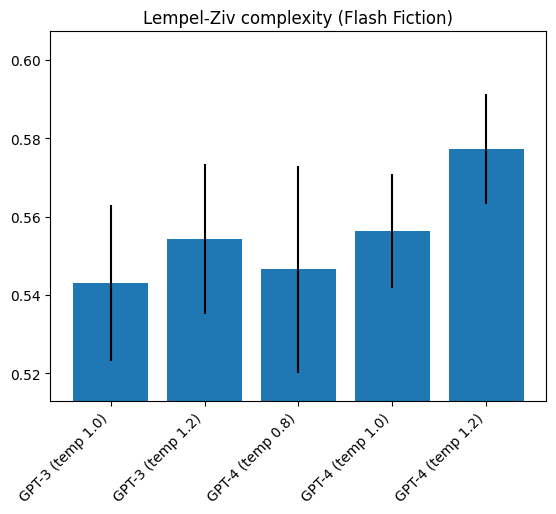

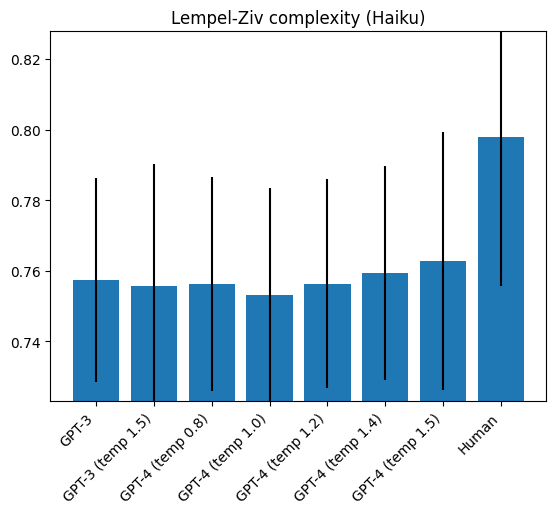

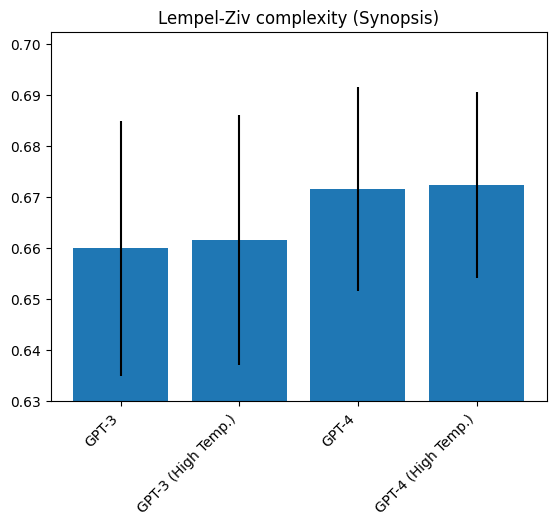

In [5]:
# flash fiction
fnames = {
    "GPT-3 (temp 1.0)": "GPT3_temp1.0_flash_fiction_nocrea100.json",
    "GPT-3 (temp 1.2)": "GPT3_temp1.2_flash_fiction_nocrea.json",
    "GPT-4 (temp 0.8)": "GPT4_temp0.8_flash_fiction_nocrea110.json",
    "GPT-4 (temp 1.0)": "GPT4_temp1.0_flash_fiction_nocrea100.json",
    "GPT-4 (temp 1.2)": "GPT4_temp1.2_flash_fiction_nocrea.json",
}
complexity_plot(fnames, "Flash Fiction")

# haiku
fnames = {
    "GPT-3": "GPT3_temp1.0_haiku_nocrea100.json",
    "GPT-3 (temp 1.5)": "GPT3_temp1.5_haiku_nocrea.json",
    "GPT-4 (temp 0.8)": "GPT4_temp0.8_haiku_nocrea110.json",
    "GPT-4 (temp 1.0)": "GPT4_temp1.0_haiku_nocrea100.json",
    "GPT-4 (temp 1.2)": "GPT4_temp1.2_haiku_nocrea130.json",
    "GPT-4 (temp 1.4)": "GPT4_temp1.4_haiku_nocrea110.json",
    "GPT-4 (temp 1.5)": "GPT4_temp1.5_haiku_nocrea.json",
    "Human": "human_haiku_tempslibres.json",
}
complexity_plot(fnames, "Haiku")

# synopsis
fnames = {
    "GPT-3": "GPT3_temp1.0_synopsis_nocrea100.json",
    "GPT-3 (High Temp.)": "GPT3_temp1.2_synopsis_nocrea.json",
    "GPT-4": "GPT4_temp1.0_synopsis_nocrea100.json",
    "GPT-4 (High Temp.)": "GPT4_temp1.2_synopsis_nocrea.json",
}
complexity_plot(fnames, "Synopsis")
